# MultiRefLfD-TPGP

## Setup

In [172]:
%reload_ext autoreload
%autoreload 2

In [196]:
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
from frechetdist import frdist

import lfd

In [197]:
lfd.set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Alignment

In [198]:
D0 = lfd.utils.load_data_with_phi("s")

fdset = lfd.utils.transform_data(D0)
P = lfd.alignment.computeP(fdset)
D0_star = lfd.alignment.align_demonstrations(fdset, P)

X = lfd.utils.transform_data(D0_star)

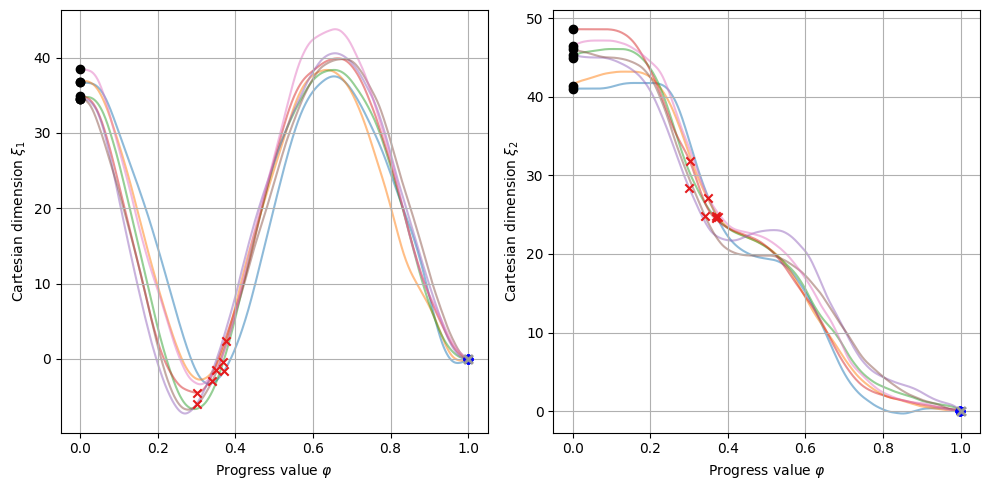

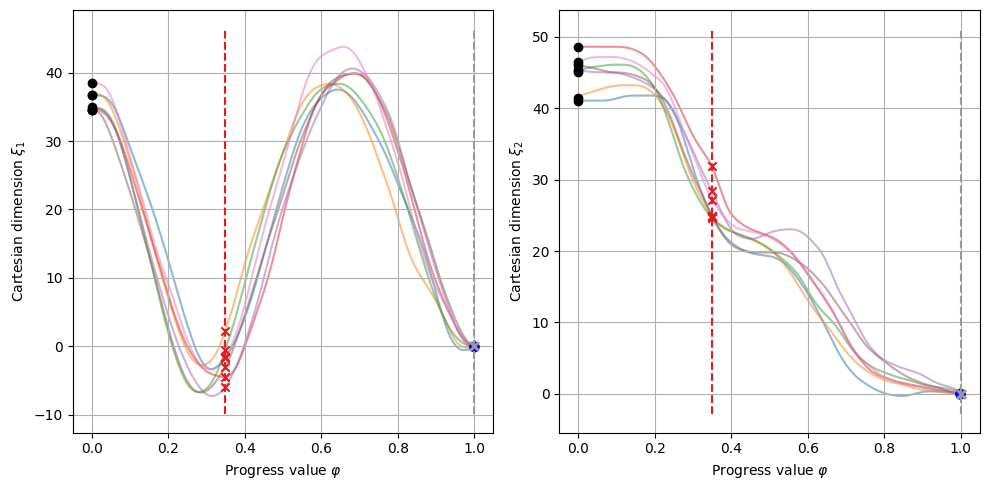

In [199]:
lfd.alignment.plot_keypoints(fdset, P)
lfd.alignment.plot_alignments(fdset, D0_star, P)

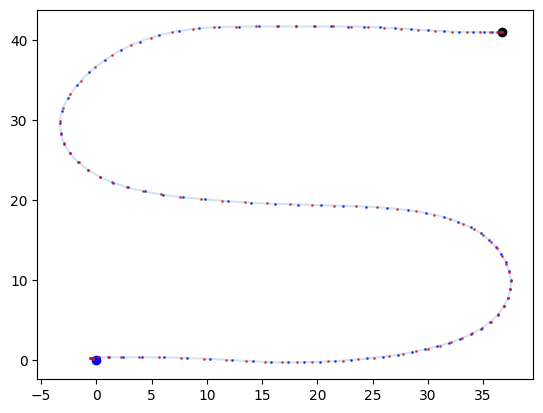

In [200]:
lfd.utils.plot_curves(D0[0:1, :, 1:], alpha=0.2)
plt.scatter(D0[0:1, ::10, 1], D0[0:1, ::10, 2], color="blue", s=1, alpha=0.7)
plt.scatter(D0_star[0:1, ::10, 1], D0_star[0:1, ::10, 2], color="red", s=1, alpha=0.7)
# plt.xlim(-10, 30)
# plt.ylim(-30, 30)
plt.show()

In [178]:
Y = np.empty_like(X)
for m, Dm in enumerate(X):
    Y[m] = lfd.utils.utils.vectorized_derivative(Dm)

In [179]:
As, Bs = lfd.utils.get_frames(D0)

X = lfd.utils.utils.toTensor(X, device=device)
Y = lfd.utils.utils.toTensor(Y, device=device)
As = lfd.utils.utils.toTensor(As, device=device)
Bs = lfd.utils.utils.toTensor(Bs, device=device)

n_frames, n_traj, n_length, n_dim = X.shape

### Frames

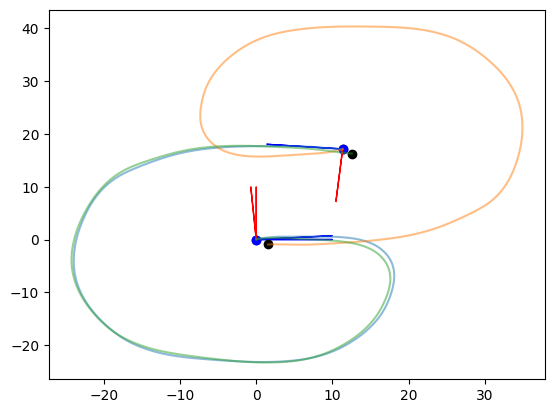

In [180]:
lfd.utils.plot_curves(fdset[0, 1:2, :, 1:], alpha=0.5)
lfd.utils.lasa.helpers.plot_frame(np.eye(3), np.zeros((3,)), 10)

lfd.utils.plot_curves(fdset[1, 1:2, :, 1:], alpha=0.5)
lfd.utils.lasa.helpers.plot_frame(As[0, 1], Bs[0, 1], 10)

lfd.utils.plot_curves(fdset[2, 1:2, :, 1:], alpha=0.5)
lfd.utils.lasa.helpers.plot_frame(As[1, 1], Bs[1, 1], 10)

## LocalPolicyGPs

In [181]:
X_train, X_val = X[1:], X[0]
Y_train, Y_val = Y[1:], Y[0]
X_train.shape, X_val.shape

(torch.Size([2, 7, 1000, 3]), torch.Size([7, 1000, 3]))

In [182]:
lgp = lfd.gp.LocalPolicyGP(X_train, Y_train, num_inducing=1000, matern_nu=2.5)

with gpytorch.settings.cholesky_jitter(1e-6):
    lgp.train(num_epochs=10, lr=0.01, notebook=True)
    # m = 0
    # model, likelihood = lgp._train_frame(
    #     X_train[m], Y_train[m], num_epochs=100, lr=0.01, notebook=True
    # )

Training GP for frame 1...


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training GP for frame 2...


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [183]:
lgp.predict_train()

In [184]:
uw_mean_preds = torch.empty_like(lgp.mean_preds)
uw_covar_preds = torch.empty_like(lgp.covar_preds)
for m in range(lgp.mean_preds.shape[0]):
    for t in range(lgp.mean_preds.shape[1]):
        Hm = As[m, t]  # (3, 3)
        Hm_inv = np.linalg.inv(Hm)
        # Hm_inv = Hm.T
        for i in range(lgp.mean_preds.shape[2]):
            uw_mean = Hm_inv @ lgp.mean_preds[m, t, i]  # (3,)
            uw_var = Hm_inv @ lgp.covar_preds[m, t, i] @ Hm  # (3, 3)
            uw_mean_preds[m, t, i] = uw_mean
            uw_covar_preds[m, t, i] = uw_var

In [185]:
import torch
import torch.nn.functional as F
import gpytorch


class FrameRelevanceGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points: Tensor):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_frame_relevance_gp(
    X_val,
    Y_val,
    mean_preds,
    covar_preds,
    n_frames,
    device,
    num_inducing=20,
    num_epochs=500,
):
    """
    X_val: shape (n_traj, n_length, n_dim)
    Y_val: shape (n_traj, n_length, n_dim)
    mean_preds: shape (n_frames, n_traj, n_length, n_dim)
    covar_preds: shape (n_frames, n_traj, n_length, n_dim, n_dim)
    """

    n_traj, n_length, n_dim = Y_val.shape

    # Flatten validation data
    phi = X_val[:, :, 0].reshape(-1, 1)  # (n_traj * n_length, 1)
    true_derivs = Y_val.reshape(-1, n_dim)  # (n_traj * n_length, n_dim)

    inducing_points = torch.linspace(0, 1, num_inducing, device=device).unsqueeze(-1)

    model = FrameRelevanceGP(inducing_points).to(device)
    likelihood = gpytorch.likelihoods.SoftmaxLikelihood(num_classes=n_frames).to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(
        [
            {"params": model.parameters()},
            {"params": likelihood.parameters()},
        ],
        lr=0.01,
    )

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(phi)
        log_probs = likelihood(outputs).logits  # (batch_size, n_frames)

        weights = F.softmax(log_probs, dim=-1)  # (batch_size, n_frames)

        # Combine local predictions
        pred_mu = torch.zeros_like(true_derivs)
        pred_sigma = torch.zeros_like(true_derivs)

        for m in range(n_frames):
            local_mean = mean_preds[m].reshape(-1, n_dim)  # (batch_size, n_dim)
            local_var = torch.stack(
                [
                    covar_preds[m, i // n_length, i % n_length].diagonal()
                    for i in range(phi.size(0))
                ],
                dim=0,
            )

            pred_mu += weights[:, m : m + 1] * local_mean
            pred_sigma += weights[:, m : m + 1] * local_var

        # Negative log likelihood loss
        loss = (
            0.5
            * ((pred_mu - true_derivs) ** 2 / pred_sigma + torch.log(pred_sigma)).sum()
        )
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

    return model, likelihood


@torch.no_grad()
def predict_frame_weights(model, likelihood, phi):
    """
    Given progress values phi (N, 1), returns frame relevance weights (N, n_frames)
    """
    model.eval()
    likelihood.eval()
    outputs = model(phi)
    logits = likelihood(outputs).logits
    weights = F.softmax(logits, dim=-1)
    return weights

In [186]:
import torch
import torch.nn as nn
# import torch.nn.functional as F

T, N, D = 7, 1000, 3

# Initialize per-sample weights
alpha = nn.Parameter(torch.rand(N, 2))

# Optimizer
optimizer = torch.optim.Adam([alpha], lr=1e-1)
mse = nn.MSELoss()

# Y_val_norm = F.normalize(Y_val, p=2, dim=-2)
for epoch in range(10000):
    optimizer.zero_grad()

    # Normalize alpha to be softmaxed (optional)
    weights = torch.softmax(alpha, dim=1)  # [N, 2]

    # Compute weighted prediction: [T, N, D]
    for t in range(T):
        f_traj = uw_mean_preds[:, t]
        pred = (weights.T.view(2, N, 1) * f_traj).sum(dim=0)
        # Normalize each [D] vector to unit norm
        # pred_norm = F.normalize(pred, p=2, dim=-2)
        # loss: Tensor = mse(pred_norm, Y_val_norm[t])
        loss: Tensor = mse(pred, Y_val[t])

        loss.backward(retain_graph=True)
        optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item()}")

Epoch 0 - Loss: 3432.801025390625
Epoch 1000 - Loss: 2450.40771484375
Epoch 2000 - Loss: 2448.33837890625
Epoch 3000 - Loss: 2448.83447265625
Epoch 4000 - Loss: 2448.493896484375
Epoch 5000 - Loss: 2448.44921875
Epoch 6000 - Loss: 2449.240234375
Epoch 7000 - Loss: 2449.40380859375
Epoch 8000 - Loss: 2448.14208984375
Epoch 9000 - Loss: 2447.00146484375


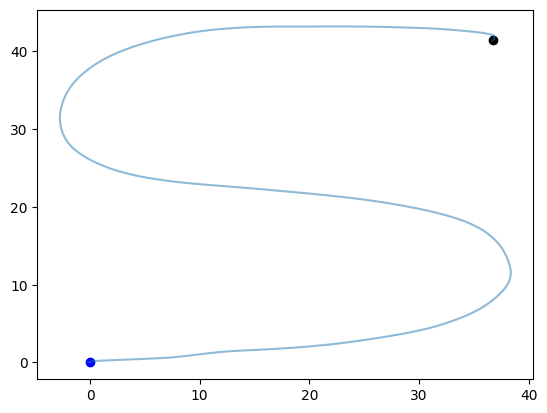

In [201]:
lfd.utils.plot_curves(X[0, 1:2, :, 1:], alpha=0.5)

In [187]:
with torch.no_grad():
    alphas = torch.softmax(alpha, dim=1)  # Shape: [N, 2]
alphas

tensor([[6.5597e-13, 1.0000e+00],
        [7.4420e-13, 1.0000e+00],
        [8.8341e-13, 1.0000e+00],
        ...,
        [4.4739e-01, 5.5261e-01],
        [2.4246e-01, 7.5754e-01],
        [3.2207e-01, 6.7793e-01]])

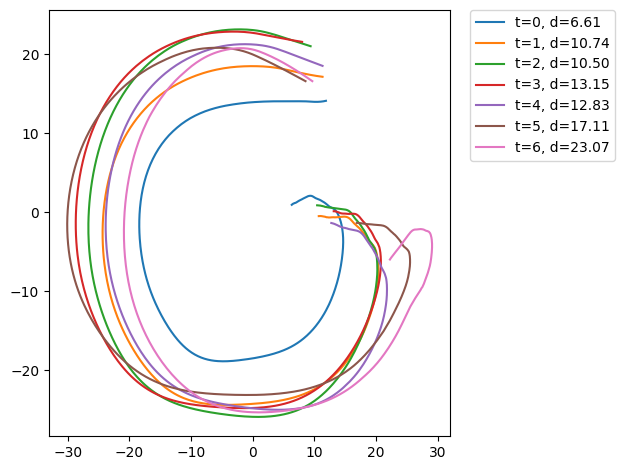

In [188]:
for t in range(7):
    x = X[0, t, 0]  # + torch.tensor([0, -5, 0])
    H = As[:, t]
    T = Bs[:, t]
    x_traj = torch.empty(1000, 3).to(device)
    for i in range(1000):
        x_traj[i] = x
        dx = alphas[i] @ lgp.predict(x, H, T, t) / 350
        x = x + dx
    dist = frdist(X[0, t], x_traj)
    plt.plot(x_traj[:, 1], x_traj[:, 2], label=f"t={t}, d={dist:.2f}")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1.0), borderaxespad=0.0)
plt.tight_layout()
plt.show()

In [189]:
delta_X = X[..., 1:, :] - X[..., :-1, :]
pad = torch.zeros_like(X[..., :1, :])
pad[..., 0, 0] = 1 / 999
delta_X = torch.cat([delta_X, pad], axis=-2)

In [190]:
def reconstructX(delta_X: Tensor, X: Tensor):
    return torch.cat([X[..., :1, :], delta_X.cumsum(dim=-2) + X[..., :1, :]], dim=-2)


def reconstructX_2(delta_X: Tensor, X: Tensor):
    return torch.cat(
        [X[1:, :, :1, :], delta_X.cumsum(dim=-2) + X[1:, :, :1, :]], dim=-2
    )


def reconstructX_3(delta_X: Tensor, X: Tensor):
    return torch.cat([X[..., :1, :], delta_X.cumsum(dim=-2) + X[..., :1, :]], dim=-2)

In [191]:
X.max()

tensor(46.0878)

In [192]:
reconstructX(delta_X, X).max() / X.max()

tensor(1.)

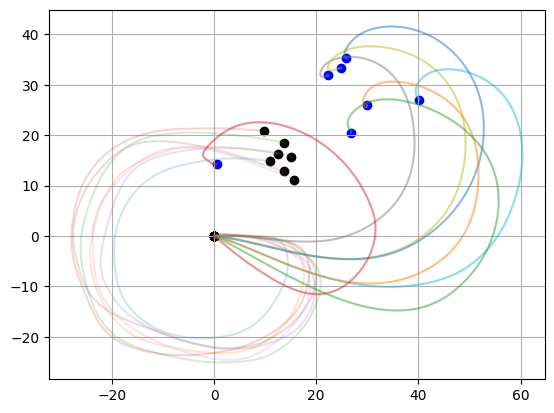

In [193]:
m = 1
# lfd.utils.plot_curves(X[m, :, :, 1:], alpha=0.2)
lfd.utils.plot_curves(X_train[m, :, :, 1:], alpha=0.2)
Xr = -reconstructX(uw_mean_preds, X_train)[m, :, :, 1:] / 700
# Xr = reconstructX(lgp.mean_preds, X_train)[m, :, :, 1:] / 700
# Xr = reconstructX(delta_X, X)[m, :, :, 1:]
lfd.utils.plot_curves(Xr, alpha=0.5)

# lfd.utils.plot_curves(lgp.mean_preds[0, :, :, 1:], alpha=0.5)
# lfd.utils.plot_curves(lgp.mean_preds[1, :, :, 1:], alpha=0.5)
plt.grid(True)
plt.show()

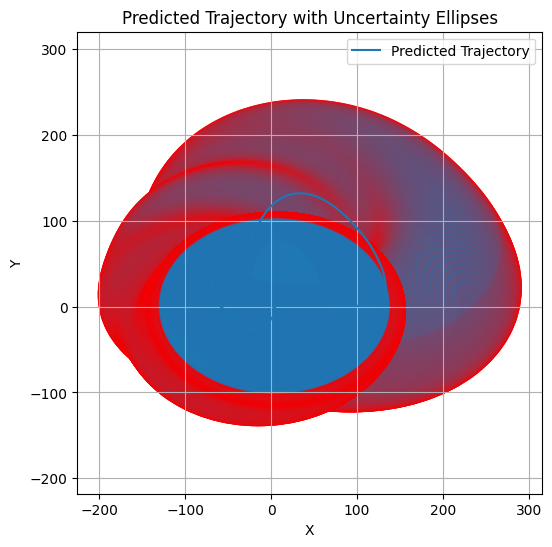

In [194]:
from matplotlib.patches import Ellipse


def plot_cov_ellipse(cov, mean, ax, n_std=2.0, **kwargs):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)


frame_idx = 0
traj_idx = 0

mean_traj = lgp.mean_preds[frame_idx, traj_idx].cpu().numpy()
cov_traj = lgp.covar_preds[frame_idx, traj_idx].cpu().numpy()

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(mean_traj[:, 1], mean_traj[:, 2], label="Predicted Trajectory")

# Plot ellipses every 100 steps
for t in range(0, mean_traj.shape[0], 1):
    cov_xy = cov_traj[t, 1:3, 1:3]
    mean_xy = mean_traj[t, 1:3]
    plot_cov_ellipse(cov_xy, mean_xy, ax, edgecolor="red", alpha=0.3)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Predicted Trajectory with Uncertainty Ellipses")
ax.legend()
ax.axis("equal")
ax.grid(True)
plt.show()